# 주식채권현금 평균모멘텀스코어 분산투자 미국 그림 2-35
- 투자기간 : 2003년 8월~2017년 6월
- 투자 대상 : 미국 S&P500지수SPY, 미국 10년 만기 국채, 20년 만기 국채TLT, 현금SHY
- 매수 규칙 : 주식 : 채권 : 현금 = S&P500지수 최근 12개월 평균 모멘텀 스코어 : 10년 (20년) 만기 국고채 지수 최근 12 개월 평균 모멘텀 스코어: 1
- 매도 규칙 : 매달 말 위의 투자 비중을 새로 계산하여 주식 :채권 : 현금 투자 비중을 조절하여 반복
- SPY 8.6%/-50.8%
- SPY+IEF+SHY : 5.5%/-4.3%
- SPY+TLT+SHY : 6.2%/-8.5%

In [1]:
from settings import *

## 데이타 읽기

In [2]:
tickers = ['SPY', 'SHY', 'IEF', 'TLT']
read_df = yf.download(tickers)['Adj Close']
read_df = read_df[tickers]
read_df.info()

[*********************100%***********************]  4 of 4 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7309 entries, 1993-01-29 to 2022-02-04
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     7309 non-null   float64
 1   SHY     4916 non-null   float64
 2   IEF     4916 non-null   float64
 3   TLT     4916 non-null   float64
dtypes: float64(4)
memory usage: 285.5 KB


In [3]:
for c in read_df.columns:
    print(c, read_df[c].first_valid_index())

SPY 1993-01-29 00:00:00
SHY 2002-07-30 00:00:00
IEF 2002-07-30 00:00:00
TLT 2002-07-30 00:00:00


In [4]:
data = read_df.dropna().copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4916 entries, 2002-07-30 to 2022-02-04
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     4916 non-null   float64
 1   SHY     4916 non-null   float64
 2   IEF     4916 non-null   float64
 3   TLT     4916 non-null   float64
dtypes: float64(4)
memory usage: 192.0 KB


In [5]:
start = '2003-08-01'
s = '2002-7-31'
e = '2017-6-30'

## 전략 Class 생성

In [6]:
class WeighAverageMomentumScoreIncludeCash(bt.Algo):
    """ 자산에 현금을 포함한 평균모멘텀스코어 전략
    
    매월초에 리밸런싱하고 전달 종가 기준으로 lookback 만큼의 월의 평균모멘텀스코어를 계산하여
    비중을 계산한다.
    """
    def __init__(self, lookback=12):
        super(WeighAverageMomentumScoreIncludeCash, self).__init__()
        self.lookback = lookback

    def average_momentum_score(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        if len(prc) != (self.lookback+1):
            raise ValueError(f"must be resample('M').last(), {prc}")
        average_momentum_score = pd.Series(dtype='float64')
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        prev_month = target.now - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        # prc = target.universe[selected].loc[start:t0]
        prc = target.universe.loc[start:t0, selected].resample('M').last()
        print(f"\nprc : {target.now} {t0} ~ {start}") #{prc}
        if len(prc) < (self.lookback+1):
            print(f"{target.now} not yet data\n")
            return False

        weights = pd.Series(self.average_momentum_score(prc), index=selected)
        weights = weights/weights.sum()

        target.temp['weights'] = weights

        return True

## 전략 생성

In [7]:
def average_momentum_score_strategy(name, data, tickers, months=12):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(), # 월초
            bt.algos.SelectThese(tickers),
            WeighAverageMomentumScoreIncludeCash(months),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000)

## 전략 실행

In [8]:
bt_spy = long_only_ew(data, ['SPY'], 'SPY')
bt_10 = average_momentum_score_strategy('SPY+IEF+SHY', data, ['SPY', 'SHY', 'IEF'])
bt_20 = average_momentum_score_strategy('SPY+TLT+SHY', data, ['SPY', 'SHY', 'TLT'])

r10 = bt.run(bt_10)


prc : 2002-07-30 00:00:00 2002-06 ~ 2001-06
2002-07-30 00:00:00 not yet data


prc : 2002-08-01 00:00:00 2002-07 ~ 2001-07
2002-08-01 00:00:00 not yet data


prc : 2002-09-03 00:00:00 2002-08 ~ 2001-08
2002-09-03 00:00:00 not yet data


prc : 2002-10-01 00:00:00 2002-09 ~ 2001-09
2002-10-01 00:00:00 not yet data


prc : 2002-11-01 00:00:00 2002-10 ~ 2001-10
2002-11-01 00:00:00 not yet data


prc : 2002-12-02 00:00:00 2002-11 ~ 2001-11
2002-12-02 00:00:00 not yet data


prc : 2003-01-02 00:00:00 2002-12 ~ 2001-12
2003-01-02 00:00:00 not yet data


prc : 2003-02-03 00:00:00 2003-01 ~ 2002-01
2003-02-03 00:00:00 not yet data


prc : 2003-03-03 00:00:00 2003-02 ~ 2002-02
2003-03-03 00:00:00 not yet data


prc : 2003-04-01 00:00:00 2003-03 ~ 2002-03
2003-04-01 00:00:00 not yet data


prc : 2003-05-01 00:00:00 2003-04 ~ 2002-04
2003-05-01 00:00:00 not yet data


prc : 2003-06-02 00:00:00 2003-05 ~ 2002-05
2003-06-02 00:00:00 not yet data


prc : 2003-07-01 00:00:00 2003-06 ~ 2002-06
2003-07

In [9]:
r20 = bt.run(bt_20)
r_spy = bt.run(bt_spy)
r = bt.run(bt_10, bt_20, bt_spy)


prc : 2002-07-30 00:00:00 2002-06 ~ 2001-06
2002-07-30 00:00:00 not yet data


prc : 2002-08-01 00:00:00 2002-07 ~ 2001-07
2002-08-01 00:00:00 not yet data


prc : 2002-09-03 00:00:00 2002-08 ~ 2001-08
2002-09-03 00:00:00 not yet data


prc : 2002-10-01 00:00:00 2002-09 ~ 2001-09
2002-10-01 00:00:00 not yet data


prc : 2002-11-01 00:00:00 2002-10 ~ 2001-10
2002-11-01 00:00:00 not yet data


prc : 2002-12-02 00:00:00 2002-11 ~ 2001-11
2002-12-02 00:00:00 not yet data


prc : 2003-01-02 00:00:00 2002-12 ~ 2001-12
2003-01-02 00:00:00 not yet data


prc : 2003-02-03 00:00:00 2003-01 ~ 2002-01
2003-02-03 00:00:00 not yet data


prc : 2003-03-03 00:00:00 2003-02 ~ 2002-02
2003-03-03 00:00:00 not yet data


prc : 2003-04-01 00:00:00 2003-03 ~ 2002-03
2003-04-01 00:00:00 not yet data


prc : 2003-05-01 00:00:00 2003-04 ~ 2002-04
2003-05-01 00:00:00 not yet data


prc : 2003-06-02 00:00:00 2003-05 ~ 2002-05
2003-06-02 00:00:00 not yet data


prc : 2003-07-01 00:00:00 2003-06 ~ 2002-06
2003-07

In [17]:
r.set_date_range(start)
r.display()

Stat                 SPY+IEF+SHY    SPY+TLT+SHY    SPY
-------------------  -------------  -------------  ----------
Start                2003-08-01     2003-08-01     2003-08-01
End                  2022-02-04     2022-02-04     2022-02-04
Risk-free rate       0.00%          0.00%          0.00%

Total Return         195.98%        221.66%        552.86%
Daily Sharpe         1.07           1.02           0.63
Daily Sortino        1.67           1.63           0.98
CAGR                 6.04%          6.51%          10.67%
Max Drawdown         -9.00%         -11.89%        -55.19%
Calmar Ratio         0.67           0.55           0.19

MTD                  -0.58%         -0.98%         -0.27%
3m                   -4.16%         -5.19%         -3.56%
6m                   0.12%          -1.47%         2.90%
YTD                  -4.66%         -5.80%         -5.53%
1Y                   10.14%         9.24%          17.74%
3Y (ann.)            9.54%          10.76%         20.16%
5Y (ann.)

In [18]:
r.prices.resample('MS').first().to_drawdown_series().describe()

,SPY+IEF+SHY,SPY+TLT+SHY,SPY
count,223.000,223.000,223.000
mean,-0.009,-0.013,-0.060
std,0.014,0.021,0.104
min,-0.078,-0.090,-0.529
25%,-0.013,-0.021,-0.061
50%,0.000,-0.002,-0.012
75%,0.000,0.000,0.000
max,0.000,0.000,0.000


In [19]:
r.set_date_range(start, e)
r.display()

Stat                 SPY+IEF+SHY    SPY+TLT+SHY    SPY
-------------------  -------------  -------------  ----------
Start                2003-08-01     2003-08-01     2003-08-01
End                  2017-06-30     2017-06-30     2017-06-30
Risk-free rate       0.00%          0.00%          0.00%

Total Return         117.52%        135.74%        224.98%
Daily Sharpe         1.20           1.07           0.55
Daily Sortino        2.00           1.79           0.86
CAGR                 5.74%          6.36%          8.84%
Max Drawdown         -8.71%         -11.89%        -55.19%
Calmar Ratio         0.66           0.53           0.16

MTD                  0.18%          0.46%          0.64%
3m                   1.72%          2.36%          2.83%
6m                   5.88%          6.64%          9.17%
YTD                  5.88%          6.64%          9.17%
1Y                   7.11%          5.54%          17.77%
3Y (ann.)            2.70%          3.37%          9.51%
5Y (ann.)     

In [20]:
r.prices.resample('MS').first().to_drawdown_series().describe()

,SPY+IEF+SHY,SPY+TLT+SHY,SPY
count,167.000,167.000,167.000
mean,-0.008,-0.014,-0.072
std,0.013,0.022,0.116
min,-0.061,-0.090,-0.529
25%,-0.011,-0.021,-0.090
50%,0.000,-0.002,-0.014
75%,0.000,0.000,0.000
max,0.000,0.000,0.000


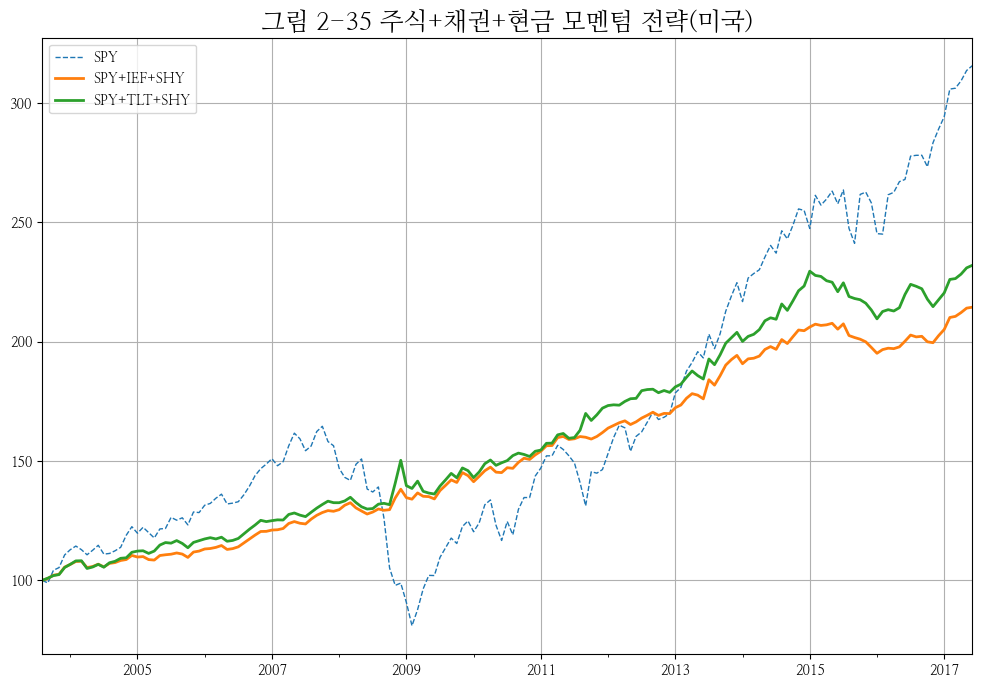

In [15]:
r_spy.set_date_range(start,e)
r10.set_date_range(start,e)
r20.set_date_range(start,e)

ax1 = r_spy.plot(freq='M', ls='--', figsize=(12, 8));
r10.plot(freq='M', ax=ax1, lw=2, figsize=(12, 8));
r20.plot(freq='M', ax=ax1, lw=2, figsize=(12, 8));
plt.title("그림 2-35 주식+채권+현금 모멘텀 전략(미국)", fontsize=18);

              CAGR
SPY+IEF+SHY  6.037
SPY+TLT+SHY  6.514
SPY         10.666
                MDD
SPY+IEF+SHY  -9.004
SPY+TLT+SHY -11.887
SPY         -55.189


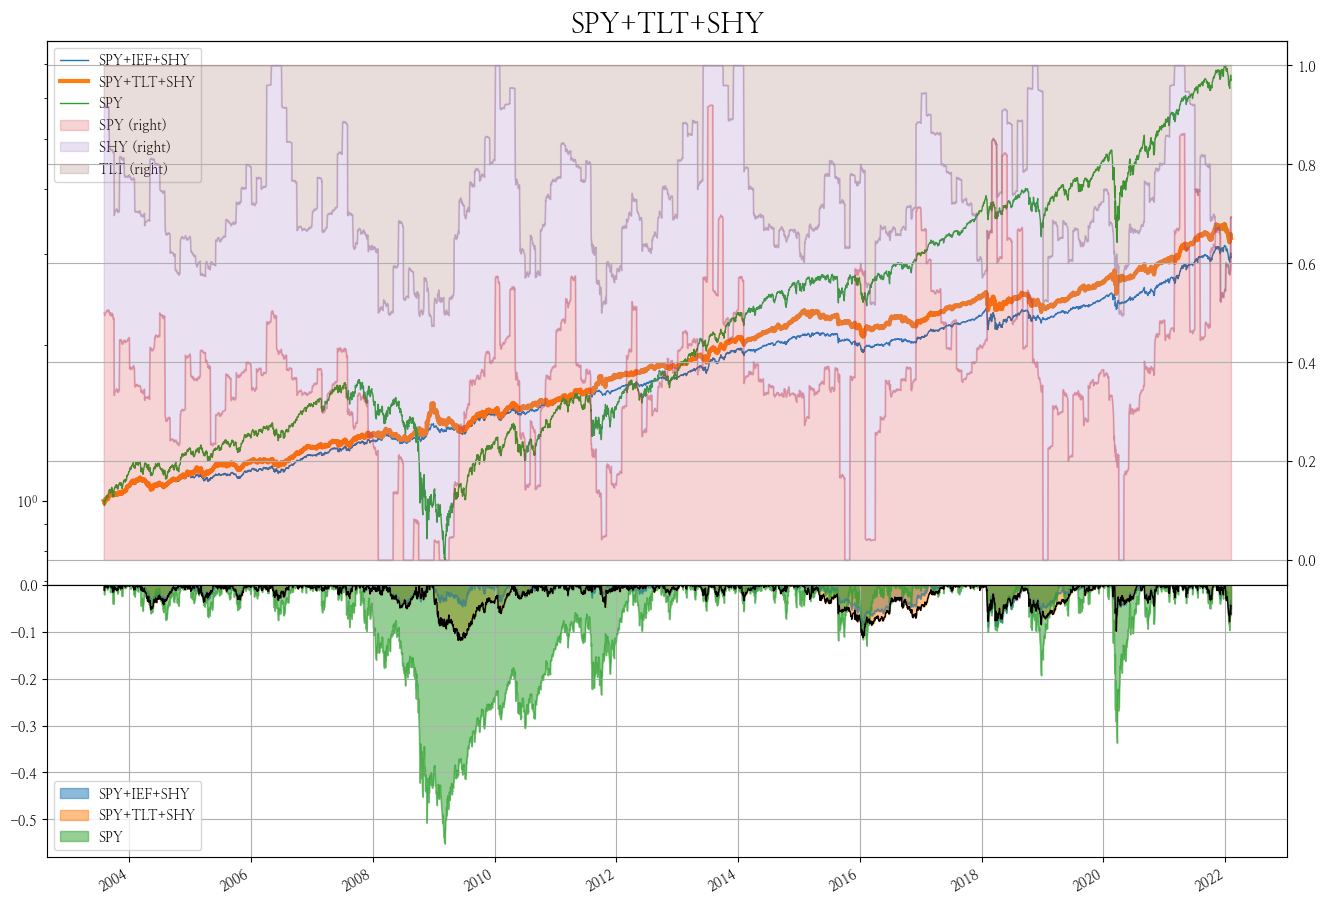

In [21]:
r_all = bt.run(bt_10, bt_20, bt_spy)
r_all.set_date_range(start)
plot_assets(r_all, start, '2022', 'SPY+TLT+SHY')

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


               CAGR
SPY+IEF+SHY  -8.355
SPY+TLT+SHY -21.006
SPY          -0.279
               MDD
SPY+IEF+SHY -7.045
SPY+TLT+SHY -7.882
SPY         -9.728


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


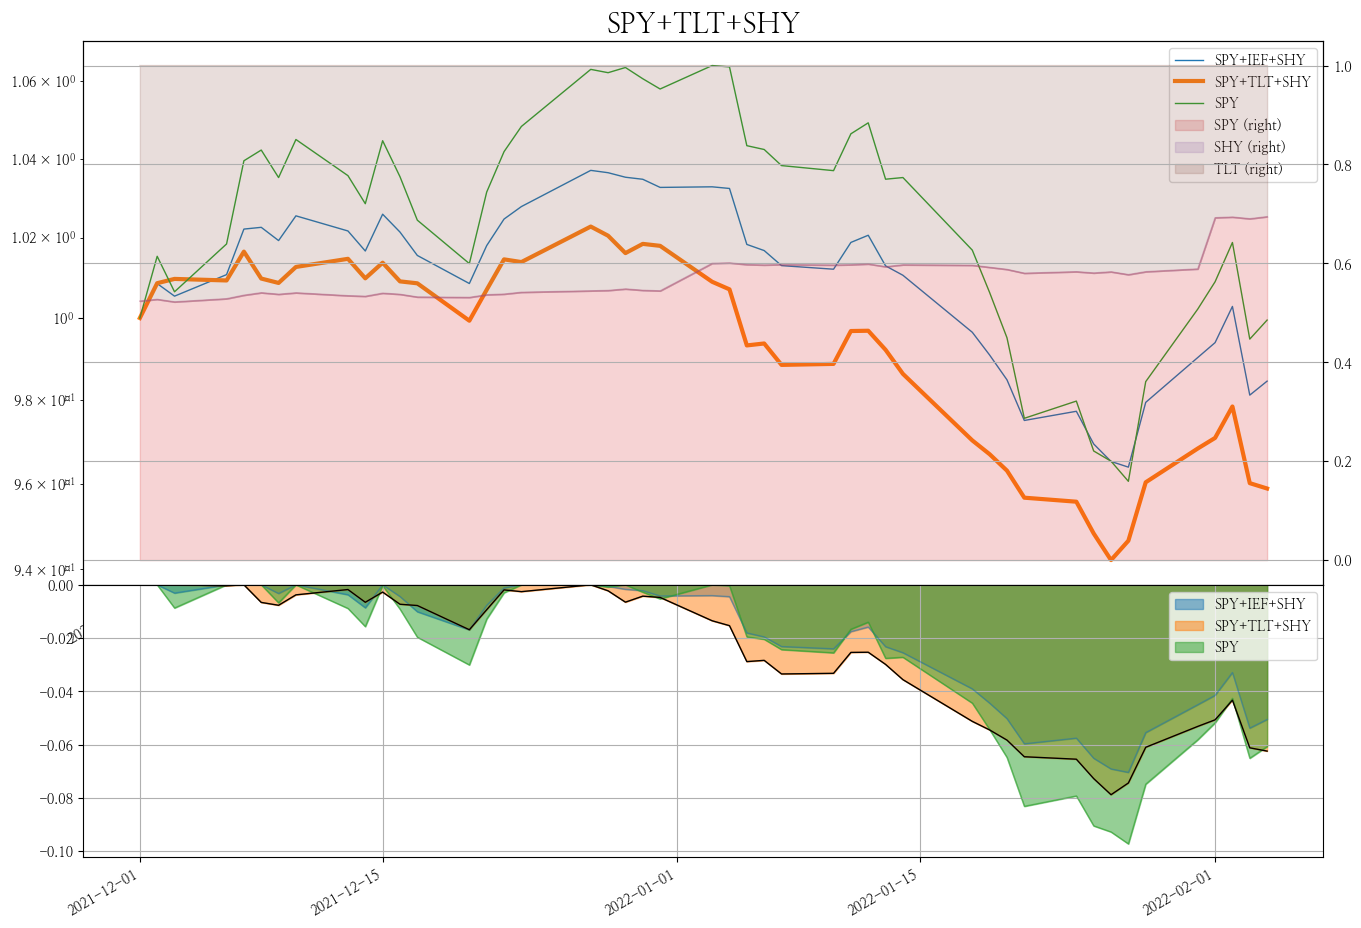

In [22]:
plot_assets(r_all, '2021-12', '2022', 'SPY+TLT+SHY')